In [ ]:
from typing import Optional
import numpy as np
import gymnasium as gym
from copy import copy
import os,random,sys
import cv2,logging
import matplotlib.pyplot as plt

In [ ]:
logging.basicConfig(
    level=logging.INFO,  # Set the logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Set the logging format
    handlers=[
        logging.StreamHandler(sys.stderr)  # Print to standard error
    ]
)

In [ ]:
apenv_cfg={"image_folder":"e:\\data\\patchagent",
            "patch_nums":[4,4],
            "stop_hr_ratio": 0.5,
            "blur_window":(401,401),
            "model_checkpoint":"microsoft/git-base", #huggingface model checkpoint, https://huggingface.co/microsoft/git-base
            "evaluator_name":"bleu", #huggingface evaluator
            
            }

In [ ]:
class ImageFolder: #load a random image from a folder
    def __init__(self, folder): 
        self.folder=folder #folder with images
        self.list_image_files()
        logging.info(f"loaded {len(self.image_files)} images from {self.folder}")

    def list_image_files(self):
        image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')
        self.image_files = []
        for root, dirs, files in os.walk(self.folder):
            for file in files:
                if file.lower().endswith(image_extensions):self.image_files.append(file)

    def get_random_image(self):return cv2.imread(os.path.join(self.folder,random.choice(self.image_files))) 

In [ ]:
from transformers import AutoModelForCausalLM
from accelerate.test_utils.testing import get_backend
from transformers import AutoProcessor
import evaluate

class CaptionModel: #run caption model and compute rewards
    def __init__(self,checkpoint="microsoft/git-base",evaluator_name="bleu"): 
        self.checkpoint,self.evaluator_name=checkpoint, evaluator_name
        self.processor = AutoProcessor.from_pretrained(self.checkpoint)
        self.model = AutoModelForCausalLM.from_pretrained(self.checkpoint)
        self.device, _, _ = get_backend()
        self.evaluator=evaluate.load(self.evaluator_name)

    def reset(self, hr_image, lr_image): #initialize with hr and lr images
        self.hr_caption=self.caption(hr_image)
        self.last_caption=self.caption(lr_image)
        self.last_similarity=self.caption_similarity(self.last_caption,self.hr_caption) #baseline, reward imporvments
        self.last_reward=0
        logging.info(f"{self.hr_caption=}  {self.last_caption=} {self.last_similarity=}")
       
    #placeholders
    def caption_similarity(self, prediction, reference):
        res=self.evaluator.compute(predictions=[prediction] ,references=[[reference]])
        return res[self.evaluator_name]
    
    def caption(self,image): 
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)
        generated_ids = self.model.generate(pixel_values=inputs.pixel_values, max_length=250)
        return self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
    def get_last_state(self):return np.zeros((2,1))  #model internal state/encoder embeddings
    def get_last_caption(self):return self.last_caption

    def reward(self,image):
        self.last_caption=self.caption(image)
        new_similarity=self.caption_similarity(self.last_caption,self.hr_caption)
        self.last_reward=new_similarity-self.last_similarity
        self.last_similarity=new_similarity
        return self.last_reward

In [ ]:
class APEnv(gym.Env):
    def __init__(self,cfg=apenv_cfg):
        self.cfg=copy(cfg)
        self.ifolder=ImageFolder(self.cfg["image_folder"])
        self.model=CaptionModel(checkpoint=cfg["model_checkpoint"],evaluator_name=cfg["evaluator_name"])

    def _get_obs(self):
        return {"image":self.composite_image,"mask":self.mask,"description":self.model.get_last_caption(),"model_state":self.model.get_last_state()}

    def _get_info(self):return None #not in use
    def info(self,msg): logging.info(msg)
    def hr_ratio(self): return np.count_nonzero(self.mask == 255)*1.0 / self.mask.size
    def is_terminated(self): return self.hr_ratio()>=self.cfg["stop_hr_ratio"]

    def compose_image(self):
        mask_3channel = cv2.merge([self.mask, self.mask, self.mask])
        self.composite_image = cv2.bitwise_and(self.hr_image, mask_3channel) + cv2.bitwise_and(self.lr_image, cv2.bitwise_not(mask_3channel))
        return self

    def fill_mask_patch(self,action):
        pw, ph=self.hr_image.shape[0]//self.cfg["patch_nums"][0],self.hr_image.shape[1]//self.cfg["patch_nums"][1]
        top_left=(action[0]*pw,action[1]*ph)
        bottom_right=(top_left[0]+pw,top_left[1]+ph)
        cv2.rectangle(self.mask, top_left, bottom_right, 255, thickness=cv2.FILLED)
        return self

    def update_state(self,action):return self.fill_mask_patch(action).compose_image()
        
    def reset(self,seed: Optional[int] = None):
        super().reset(seed=seed)
        
        self.hr_image=self.ifolder.get_random_image()
        self.lr_image=cv2.GaussianBlur(self.hr_image, self.cfg["blur_window"], 0)
        self.mask=np.zeros(self.hr_image.shape[0:2],dtype=np.uint8)
        self.model.reset(self.hr_image, self.lr_image)
        self.compose_image()

        return self._get_obs(),self._get_info()

    def step(self,action):
        reward=self.update_state(action).model.reward(self.composite_image)
        return self._get_obs(), reward, self.is_terminated(), False, self._get_info()
    
    def random_action(self): return (random.randint(0,self.cfg["patch_nums"][0]-1),random.randint(0,self.cfg["patch_nums"][1]-1))

    def render(self):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(self.composite_image)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(self.mask)
        plt.axis('off')
        plt.suptitle(f"caption:{self.model.last_caption}  ratio:{self.hr_ratio():.2f}")
        plt.show()



2025-02-04 15:27:57,229 - root - INFO - loaded 3 images from e:\data\patchagent
e:\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2025-02-04 15:28:05,517 - root - INFO - self.hr_caption='the road is made of dirt'  self.last_caption='white line on road' self.last_similarity=0.0


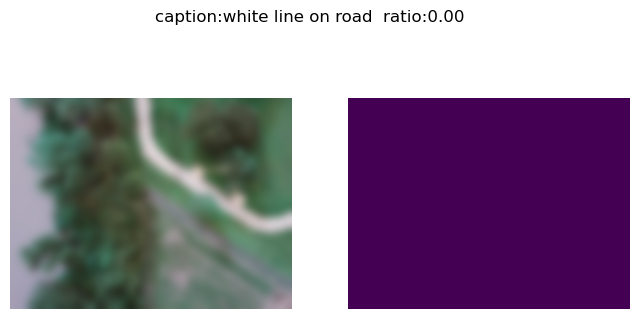

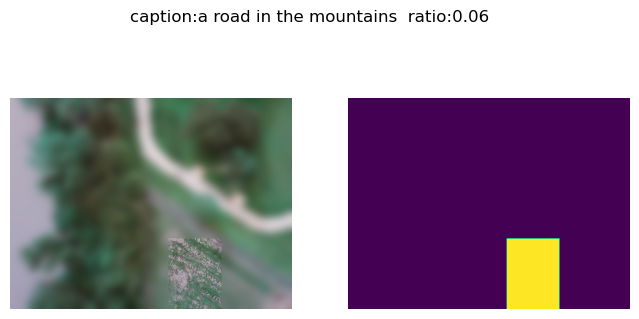

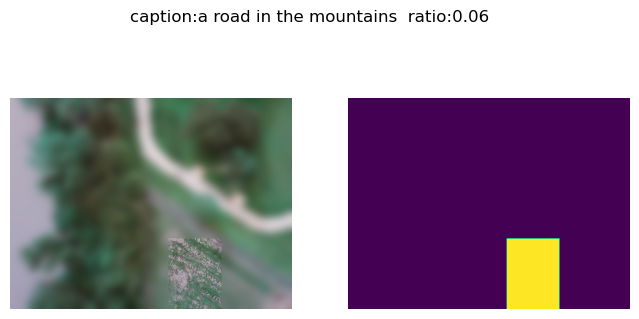

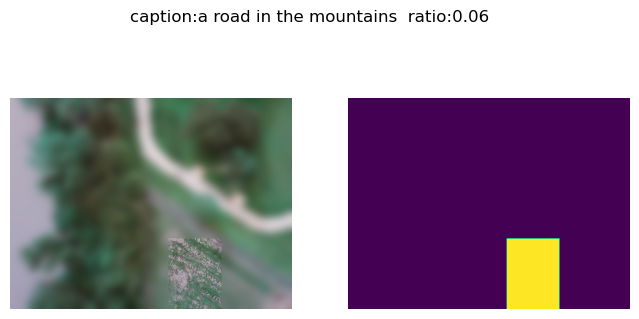

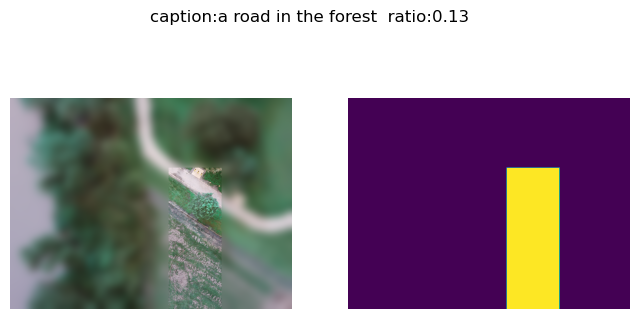

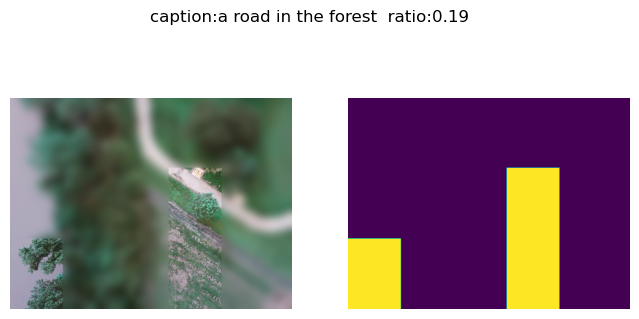

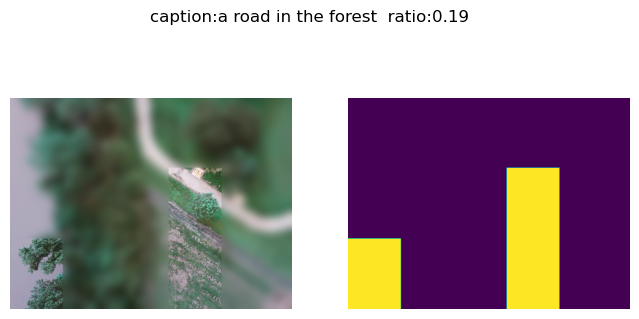

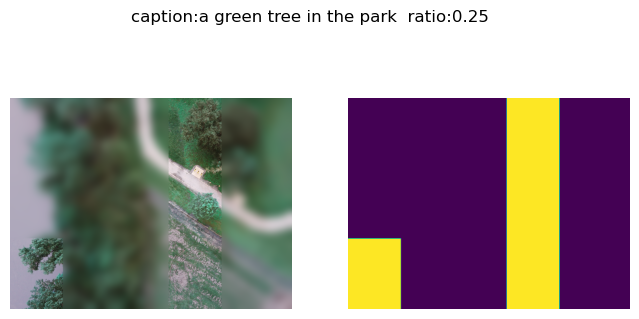

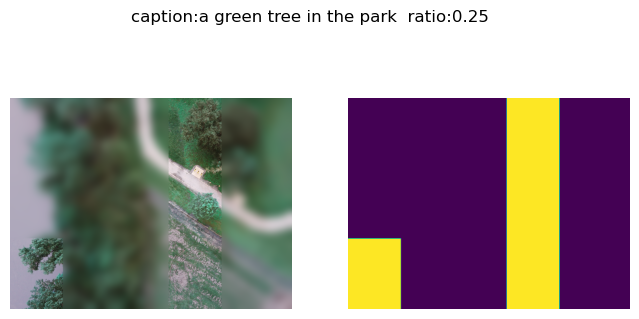

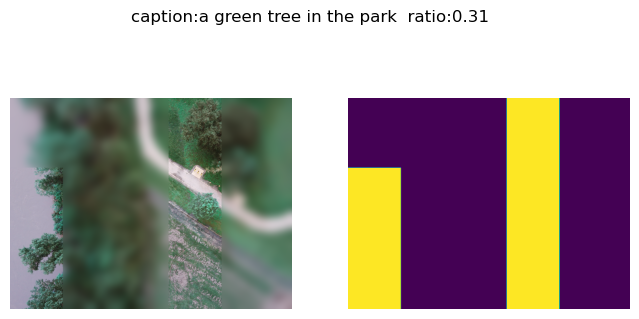

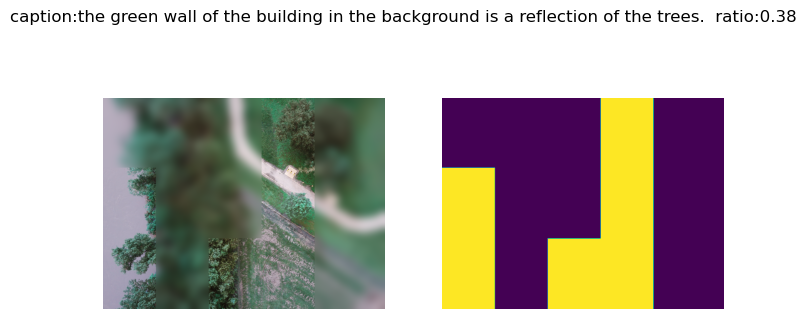

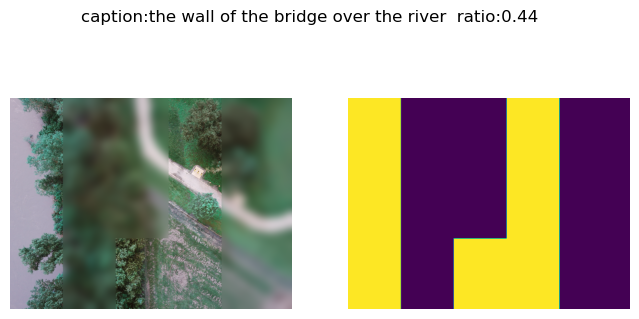

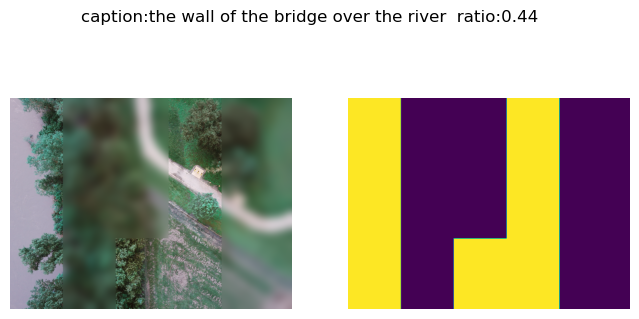

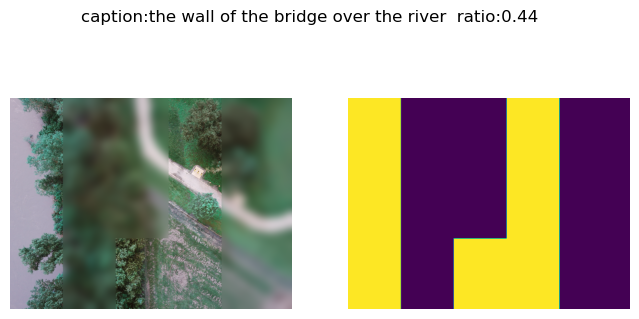

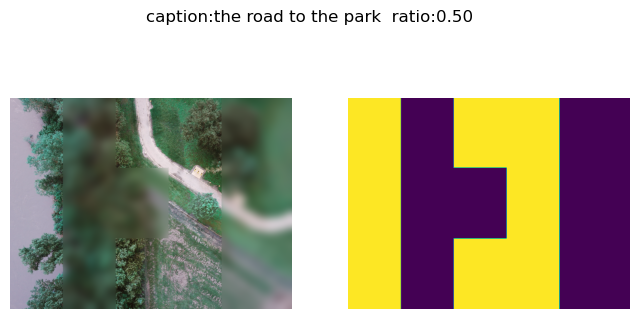

In [ ]:
#enviornment
ape=APEnv()

#load random image
ape.reset()
ape.render()

#loop till 50% of HR pages
#randomly select patch with replacment (sometimes hit already selected HR patch)
terminated=False
while(not terminated):
    observations, reward,terminated,_,___=ape.step(ape.random_action())
    ape.render()
